In [231]:
#| default_exp group

# Group

> Module for creating groups of the transcript, specifically for paragraphs, speakers, and topics.

# Information

This module will provide the functionality of splitting our fully transcribed text into desired groups. The grouping hierarchy in order from smallest to largest:

1. Sentences
2. Paragraphs
3. Speaker's Speech
4. Topics

We'll want to preserve consistency here, so the format of the functions should remain similar, and the inputs / outputs should the same. 

It would be good to preserve the timestamp information on the word-level as the output, so we keep these in all the groupings. The grouping methods will then deal with arrays of sentences, containing arrays of word objects. Since the topic, and paragraph splitting is done on sentence embeddings, we make all functions take in sentences as the input. The outputs will then be these sentences grouped together.

# Groups

## Sentences

In order to group sentences, we first need to get a list of sentences. This is easily done, we simply split the words whenever there is a full stop (or '!'/'?'). 

There's one more condition though and that's the minimum length of the sentence. This is quite important, as we are making groups based on the similarity of embeddings. Small sentences containing short utterances could skew the split points disproportionately. So here we could either join sentences together, or remove them from the consideration. 

If we remove them from the consideration, we'd need some way of determining which group they go into ie. whether there's a cutoff before or after them. This might be a bit too complicated, as well as this it is possible that they contain information relavent to the consideration. So here we'll just join short sentences together.

## Paragraphs

### Aims

Straightforward requirements here, and that is to introduce a method that can quickly split lengthy text into separate paragraphs. 

The only use case here is for increased readability, so accuracy isn't at utmost importance.

### Approach

Found [a method online](https://github.com/poloniki/quint/blob/master/notebooks/Chunking%20text%20into%20paragraphs.ipynb) which takes embeddings of sentences, and finds split points at points of a significant change between them.

## Speakers

From the diarized transcript, we simply want to be able to group segemnets where the speaker doesn't change, to display as one in the final output.

## Topics

### Aims

Always useful to consider, and reconsider your aims when researching. 

We are looking for a way of grouping up chapters or topics of the text. 

The purpose or exact use cases should be considered. Currently I am looking for a tool that can be used for revision of a podcast, though I can of course see it being used further as the sole way of getting a podcast's content. So if possible, choosing methods that would allow both would ideal, but the focus should be kept to the former.

So the objective of the former rereading method asks for a lot less. It simply requires the core ideas to be displayed in any format, to only allow the reader to remind themselves what at point of the conversation this was mentioned. This can be done simply by displaying the keywords found by the topics.

From the no-listen perspective, more is required from the topics. The splits could be the same, but the labels would need to be more descriptive. Although, this might be the wrong way of thinking about it. What would be required from a reading perspective is real summaries, accurate, and concise in their requirements.

### Approach

What we require here is a way of first grouping the text into topics, and then finding a way to summarise them through a title (and possibly a paragraph summary).

### Clustering

There are various different ways of splitting the topics, which all come under the category 'Topic Modelling.' They tend to be statistical methods concerned with creating embeddings of the text, reducing their dimensionality, and then clustering them. 

### Summarisation

For the latter, LLM's seem like the perfect use case for this as a summarisation task. They are excellent at summarising as they do have some way of understanding language, and are also able to output that understanding into words. The only issue with this approach is the cost, as they are much more computationally costly as a direct method designed for the task.

# Implementation

## Setup

In [232]:
#| export
import pandas as pd
import numpy as np
from pathlib import Path
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.signal import argrelextrema
import math
from nltk.stem import WordNetLemmatizer
from nltk import download
from functools import partial, update_wrapper

In [233]:
import json
import seaborn as sns
import matplotlib.pyplot as plt

In [234]:
#| export 
download("wordnet")
embedding_model = SentenceTransformer('all-mpnet-base-v2')

[nltk_data] Downloading package wordnet to /home/steph/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [235]:
with open("../data/podcast/practical_ai_236_tech_stack/tmp/transcript.json") as f:
    transcript = json.load(f)

## Sentences

In [236]:
#| export
def group_sentences(words, min_length=10):
    group_idxs = [0]
    for i, w in enumerate(words):
        w = w['word'].replace('?', '.')
        if (w.endswith('.') or w.endswith('. ')) and (i - (group_idxs[-1] + 1)) >= min_length: 
            group_idxs.append(i+1)
    if len(group_idxs) > 1:
        group_idxs.pop()
    sentences = [ words[i:j] for i, j in zip(group_idxs, group_idxs[1:]+[None]) ]
    return sentences, group_idxs

In [237]:
#| export
# wrapper around original function to be used for pure text
def group_sentences_text(text):
    words = [{"word": w} for w in text.split(" ")]
    sentences, _ = group_sentences(words)
    return sentences

In [238]:
transcript_text = ' '.join([word['word'] for word in transcript['words']])
sentences = group_sentences_text(transcript_text)[0]

In [239]:
sentences_indexed = group_sentences(transcript['words'])
sentences, sentence_idxs  = sentences_indexed
sentences[1][:3], sentence_idxs[1]

([{'word': 'Thank',
   'start': 19.361,
   'end': 19.561,
   'score': 0.867,
   'speaker': 'SPEAKER_01'},
  {'word': 'you',
   'start': 19.581,
   'end': 19.721,
   'score': 0.748,
   'speaker': 'SPEAKER_01'},
  {'word': 'to',
   'start': 19.741,
   'end': 19.821,
   'score': 0.992,
   'speaker': 'SPEAKER_01'}],
 29)

In [240]:
#| export
# flattening sentence array
def sentences_to_words(sentences):
    return [word for sentence in sentences for word in sentence]

## Paragraphs

A simple task of finding points where long periods of text can be divided into paragraphs.

In [241]:
embeddings = embedding_model.encode(sentences)
embeddings.shape

(259, 768)

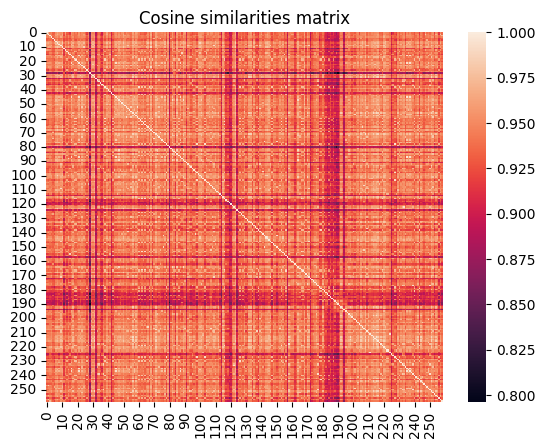

In [242]:
similarity_matrix =  cosine_similarity(embeddings)
sns.heatmap(similarity_matrix).set_title('Cosine similarities matrix');

In [243]:
#| export
def rev_sigmoid(x:float)->float:
    return (1 / (1 + math.exp(0.5*x)))
    
def activate_similarities(similarities:np.array, p_size=10)->np.array:
        """ Function returns list of weighted sums of activated sentence similarities
        Args:
            similarities (numpy array): it should square matrix where each sentence corresponds to another with cosine similarity
            p_size (int): number of sentences are used to calculate weighted sum 
        Returns:
            list: list of weighted sums
        """
        # To create weights for sigmoid function we first have to create space. P_size will determine number of sentences used and the size of weights vector.
        x = np.linspace(-10,10,p_size)
        # Then we need to apply activation function to the created space
        y = np.vectorize(rev_sigmoid) 
        # Because we only apply activation to p_size number of sentences we have to add zeros to neglect the effect of every additional sentence and to match the length ofvector we will multiply
        activation_weights = np.pad(y(x),(0,similarities.shape[0]-p_size))
        ### 1. Take each diagonal to the right of the main diagonal
        diagonals = [similarities.diagonal(each) for each in range(0,similarities.shape[0])]
        ### 2. Pad each diagonal by zeros at the end. Because each diagonal is different length we should pad it with zeros at the end
        diagonals = [np.pad(each, (0,similarities.shape[0]-len(each))) for each in diagonals]
        ### 3. Stack those diagonals into new matrix
        diagonals = np.stack(diagonals)
        ### 4. Apply activation weights to each row. Multiply similarities with our activation.
        diagonals = diagonals * activation_weights.reshape(-1,1)
        ### 5. Calculate the weighted sum of activated similarities
        activated_similarities = np.sum(diagonals, axis=0)
        return activated_similarities

In [244]:
# Let's apply our function. For long sentences i reccomend to use 10 or more sentences
activated_similarities = activate_similarities(similarity_matrix, p_size=10)

# Find relative minima of our vector. For all local minimas and save them to variable with argrelextrema function
minimas = argrelextrema(activated_similarities, np.less, order=2) #order parameter controls how frequent should be splits. I would not reccomend changing this parameter.

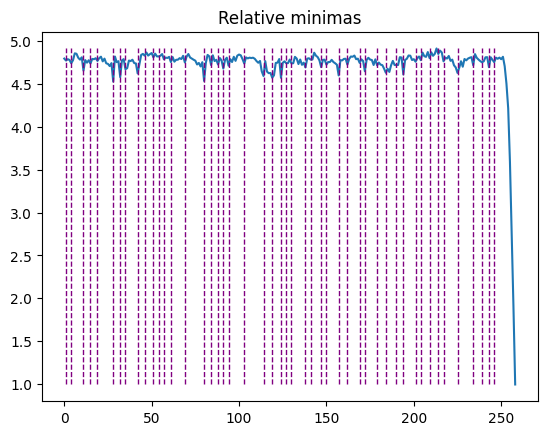

In [245]:
# Let's create empty fig for our plor
fig, ax = plt.subplots()
# plot the flow of our text with activated similarities
sns.lineplot(y=activated_similarities, x=range(len(activated_similarities)), ax=ax).set_title('Relative minimas');
# Now lets plot vertical lines in order to see where we created the split
plt.vlines(x=minimas, ymin=min(activated_similarities), ymax=max(activated_similarities), colors='purple', ls='--', lw=1, label='vline_multiple - full height')

In [246]:
#| export
def split_on_minimas(sentences, minimas):
    group_idxs = [ m for m in minimas[0] ]
    group_idxs.insert(0,0)
    paragraphs = [ sentences[i:j] for i, j in zip(group_idxs, group_idxs[1:]+[None]) ]
    return paragraphs, group_idxs

In [247]:
#| export
def get_abs_indexes(sentence_idxs, relative_indexes):
    return [ sentence_idxs[i] for i in relative_indexes ]

In [248]:
#| export
def group_paragraphs(sentences):
    if len(sentences) < 8: 
        return [sentences], [0]
    sentences_text = [ ' '.join([ word['word'] for word in s ]) for s in sentences ]
    embeddings = embedding_model.encode(sentences_text)
    similarities = cosine_similarity(embeddings)
    activated_similarities = activate_similarities(similarities, p_size=8)
    minimas = argrelextrema(activated_similarities, np.less, order=2)
    paragraphs, group_idxs = split_on_minimas(sentences, minimas)
    return paragraphs, group_idxs

In [249]:
#| export
# wrapped around original function to be used with pure text as opposed to sentence grouped words
def group_paragraphs_text(text):
    words = [{"word": w} for w in text.split(" ")]
    sentences, _ = group_sentences(words)
    paragraphs, _ = group_paragraphs(sentences)
    paragraphs = '\n\n'.join([ ' '.join([  ' '.join([ word['word'] for word in sentence ]) for sentence in paragraph ]) for paragraph in paragraphs ])
    return paragraphs

In [250]:
paragraphs = group_paragraphs_text(transcript_text)
paragraphs

"Oh. Welcome to Practical AI. If you work in artificial intelligence, aspire to, or are curious how AI-related technologies are changing the world, this is the show for you. Thank you to our partners at Fastly for shipping all of our pods super fast to wherever you listen.\n\nCheck them out at fastly.com. And to our friends at Fly, deploy your app servers and database close to your users. No ops required. Learn more at fly.io. Bye! Welcome to another Fully Connected episode of Practical AI. In these episodes, Chris and I keep you fully connected with everything that's happening in the AI community. We'll cover some of the latest news and we'll cover some learning resources that'll help you level up your machine learning game. I'm Daniel Whitenack. I'm the founder of Prediction Guard and I'm joined as always by my co-host, Chris Benson, who is a tech strategist at Lockheed Martin. How you doing, Chris? very well today, Daniel. How are you? I'm doing great. I am uncharacteristically join

In [251]:
paragraphs, paragraph_idxs = group_paragraphs(sentences[:40])
paragraphs[0][0][:3]

[{'word': 'Oh.',
  'start': 5.088,
  'end': 5.13,
  'score': 0.038,
  'speaker': 'SPEAKER_01'},
 {'word': 'Welcome',
  'start': 7.178,
  'end': 7.538,
  'score': 0.843,
  'speaker': 'SPEAKER_01'},
 {'word': 'to',
  'start': 7.598,
  'end': 7.758,
  'score': 0.872,
  'speaker': 'SPEAKER_01'}]

In [252]:
print([ len(paragraph) for paragraph in paragraphs ])

[2, 7, 6, 3, 3, 4, 7, 8]


## Topics

### Topic Modelling Methods

#### Cosine Similarity Minima

Trying out applying the minima at paragraph-level to obtain topics.

-> Deleted as methods changed. Revamp when investigating

### Clustering

Trying out simple clustering on embedded vectors of sentences/paragraphs.

This is at minimum a 2-step process. First we need to embed our sentences, and then cluster them into topics.

#### Embeddings

In [253]:
from sentence_transformers import SentenceTransformer

In [254]:
sentence_embeddings = sentence_model.encode(sentences)
sentence_embeddings.shape

(259, 768)

In [255]:
#| export
def get_position_embeddings(seq_len, d, n=1000):
    P = np.zeros((seq_len, d))
    for k in range(seq_len):
        for i in np.arange(int(d/2)):
            denominator = np.power(n, 2*i/d)
            P[k, 2*i] = np.sin(k/denominator)
            P[k, 2*i+1] = np.cos(k/denominator)
    return P

In [256]:
position_embeddings = get_position_embeddings(*sentence_embeddings.shape)
position_embeddings.shape

(259, 768)

In [257]:
print(np.min(sentence_embeddings), np.max(sentence_embeddings))
print(np.min(position_embeddings), np.max(position_embeddings))

-0.14550272 0.15024488
-0.9999999999302351 1.0


In [258]:
position_embeddings = position_embeddings * (np.max(sentence_embeddings) / np.max(position_embeddings))
print(np.min(position_embeddings), np.max(position_embeddings))

-0.15024487673188117 0.15024487674236298


In [259]:
#| export
def get_embeddings(sentences):
    sentence_embeddings = embedding_model.encode(sentences)
    position_embeddings = get_position_embeddings(*sentence_embeddings.shape)
    position_embeddings = position_embeddings * (np.max(sentence_embeddings) / np.max(position_embeddings)) # scale to match sentence embeddings
    return sentence_embeddings + position_embeddings

#### Clustering

Decision: Cluster sentences or paragraphs?

I think this depends whether the paragraph splitting is good or not. Are the paragraph splitting more or less likely to find the best topic splits.

### Number of Topics

In [260]:
#| export
from sklearn.cluster import KMeans

We have one constraint for this, and that is to keep topic lengths under the 4096 token limit for the summarisation LLM's context window.

Giving space for the prompt header we'd like to go under 3700 tokens, which in words is:

In [261]:
3700/1.4

2642.857142857143

That's a lot of room to work with, this is much longer than a conversation point usually holds for. 

Deciding on the average length of a topic is rather arbitrary, and there aren't any constraints that are required aside from the 2500 max length. Let's just say that a topic should usually hold for 1000 words.

In [262]:
#| export
def get_n_topics(words, soft_max_n=20):
    n_topics = math.ceil(len(words) / 1000)
    if n_topics > soft_max_n: 
        n_topics = soft_max_n
        if len(words)/n_topics > 2500:
            n_topics = math.ceil(len(words)/soft_max_n)
    return n_topics

In [263]:
n_topics = get_n_topics(transcript['words'])

In [264]:
final_embeddings = sentence_embeddings+position_embeddings

In [265]:
clusters = KMeans(n_clusters=n_topics).fit(final_embeddings)

In [266]:
sentences_clustered = list(zip(clusters.labels_, sentences))

In [267]:
#| export
# splitting topics into consecutive topics 
def get_topic_splits(sentences_clustered):
    group_idxs = [0]
    for i in range(1, len(sentences_clustered)):
        if sentences_clustered[i][0] != sentences_clustered[i-1][0]: 
            group_idxs.append(i)
    return group_idxs

In [268]:
group_idxs = get_topic_splits(sentences_clustered)
topic_idxs = get_abs_indexes(sentence_idxs, group_idxs)

In [269]:
#| export
def group_topics(sentences, n_topics=None):
    if not n_topics: n_topics = get_n_topics(sentences_to_words(sentences))
    sentences_text = [ ' '.join([ word['word'] for word in s ]) for s in sentences ]
    embeddings = get_embeddings(sentences_text)
    clusters = KMeans(n_clusters=n_topics).fit(embeddings)
    sentences_clustered = list(zip(clusters.labels_, sentences))
    group_idxs = get_topic_splits(sentences_clustered)
    topics = [ sentences[i:j] for i, j in zip(group_idxs, group_idxs[1:]+[None]) ]
    return topics, group_idxs

In [270]:
topics, topic_idxs = group_topics(sentences)
len(topics)

8

### Visualisation

In [271]:
# Find the closest embeddings to the centroids

# Create an empty list that will hold your closest points
closest_indices = []

# Loop through the number of clusters you have
for i in range(n_topics):
    
    # Get the list of distances from that particular cluster center
    distances = np.linalg.norm(final_embeddings - clusters.cluster_centers_[i], axis=1)
    
    # Find the list position of the closest one (using argmin to find the smallest distance)
    closest_index = np.argmin(distances)
    
    # Append that position to your closest indices list
    closest_indices.append(closest_index)

closest_indices.sort()
closest_indices

[13, 44, 73, 111, 148, 180, 212, 245]

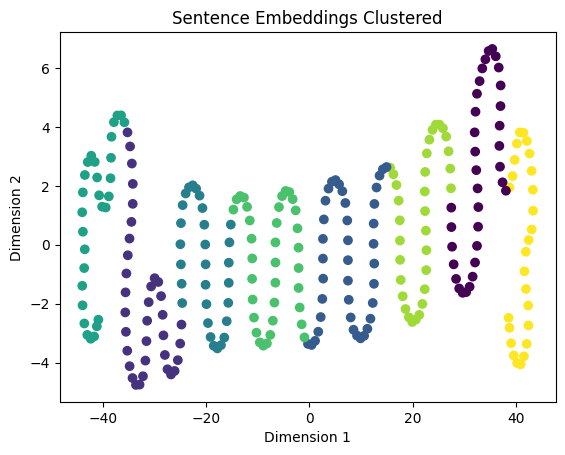

In [272]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Taking out the warnings
import warnings
from warnings import simplefilter

# Filter out FutureWarnings
simplefilter(action='ignore', category=FutureWarning)

# Perform t-SNE and reduce to 2 dimensions
tsne = TSNE(n_components=2, random_state=42)
reduced_data_tsne = tsne.fit_transform(final_embeddings)

# Plot the reduced data
plt.scatter(reduced_data_tsne[:, 0], reduced_data_tsne[:, 1], c=clusters.labels_)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Sentence Embeddings Clustered')
plt.show()

### Comparing with Labelled Data

To compare the results we can use the topics supplied in the [podcast's RSS feed](https://lexfridman.com/feed/podcast/) as a reference.

In [273]:
with open("../data/podcast/practical_ai_236_tech_stack/topics.txt") as f:
    ref_labels_text = f.read()

In [274]:
from datetime import datetime

In [275]:
def timestamp_to_seconds(timestamp):
    if len(timestamp.split(":")) == 3:
        timestamp = datetime.strptime(timestamp, "%H:%M:%S")
    else:
        timestamp = datetime.strptime(timestamp, "%M:%S")
    datetime_base = datetime.strptime("00:00:00", "%H:%M:%S")
    return (timestamp-datetime_base).seconds

In [276]:
def get_timestamp_word_index(timestamp):
    for i, w in enumerate(transcript['words']):
        if int(w['start']) >= timestamp:
            return i

In [277]:
def get_topic_obj(topic_line):
    split = topic_line.split('	')
    heading = split[2]
    timestamp = split[1]
    timestamp_s = timestamp_to_seconds(timestamp)
    word_idx = get_timestamp_word_index(timestamp_s)
    return {'heading': heading, 'timestamp': timestamp, 'word_idx': word_idx}

In [278]:
ref_labels = list(map(get_topic_obj, ref_labels_text.splitlines()))

In [279]:
pd.DataFrame(ref_labels)

,heading,timestamp,word_idx
0,Welcome to Practical AI,00:07,1
1,Deep dive into LLMs,00:43,77
2,Emerging LLM app stack,02:25,364
3,Playgrounds,04:35,698
4,App Hosting,08:07,1316
5,Stack orchestration,10:46,1777
6,Maintenance breakdown,15:50,2569
7,Sponsor: Changelog News,19:08,3079
8,Vector databases,20:43,3284
9,Embedding models,22:36,3566


In [280]:
topics, topic_idxs = group_topics(sentences, 18)

In [281]:
topic_word_idxs = get_abs_indexes(sentence_idxs, topic_idxs)

In [282]:
print(len(topic_word_idxs), len(ref_labels))
print(topic_word_idxs)
print([l['word_idx'] for l in ref_labels])

18 18
[0, 289, 765, 1106, 1507, 1988, 2361, 2716, 3079, 3458, 3845, 4183, 4756, 5151, 5518, 5858, 6071, 6479]
[1, 77, 364, 698, 1316, 1777, 2569, 3079, 3284, 3566, 3845, 4255, 4698, 5175, 5869, 6375, 6660, 6961]


To define a metric to evaluate the quality here we could have something like the following: 

For each topic in the reference label, is there a splitpoint within a certain leeway. (2.5% of word count).

In [283]:
len(transcript['words']) * 0.025

176.4

In [284]:
for labelled_t in ref_labels:
    idx_found = labelled_t['word_idx']
    labelled_t['found'] = False
    for idx_labelled in topic_word_idxs:
        if abs((idx_found - idx_labelled)/len(transcript['words'])) < 0.025:
            labelled_t['found'] = True
            continue

In [285]:
pd.DataFrame(ref_labels)

,heading,timestamp,word_idx,found
0,Welcome to Practical AI,00:07,1,True
1,Deep dive into LLMs,00:43,77,True
2,Emerging LLM app stack,02:25,364,True
3,Playgrounds,04:35,698,True
4,App Hosting,08:07,1316,False
5,Stack orchestration,10:46,1777,False
6,Maintenance breakdown,15:50,2569,True
7,Sponsor: Changelog News,19:08,3079,True
8,Vector databases,20:43,3284,True
9,Embedding models,22:36,3566,True


In [286]:
found_count = len([topic for topic in ref_labels if topic['found']])
print(len(ref_labels), len(topic_word_idxs), found_count)

18 18 14


Out of the topics found, all but three were within our reference. 

#### Topic Lengths

Are the the topic length simply just evenly spaced out?

In [287]:
topic_lengths = [(topic_word_idxs[i+1] - topic_word_idxs[i])/len(transcript['words']) for i in range(len(topic_word_idxs)-1)]
np.mean(topic_lengths), np.std(topic_lengths)

(0.05401327197545685, 0.010887701175409083)

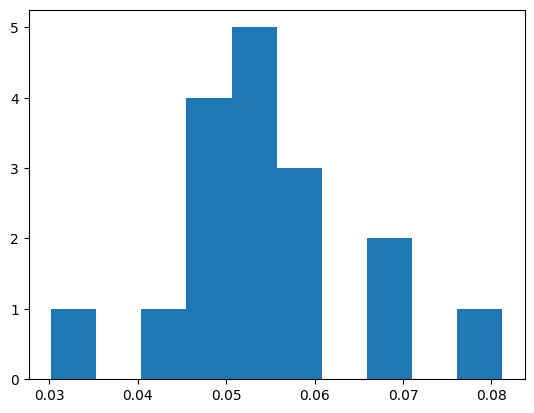

In [288]:
plt.hist(topic_lengths);

It looks like there's enough variation in topics to not judge it as evenly spaced.

In [289]:
baseline = np.linspace(0,topic_word_idxs[-1],15).astype(int)
print(baseline)
print(topic_word_idxs)

[   0  462  925 1388 1851 2313 2776 3239 3702 4165 4627 5090 5553 6016
 6479]
[0, 289, 765, 1106, 1507, 1988, 2361, 2716, 3079, 3458, 3845, 4183, 4756, 5151, 5518, 5858, 6071, 6479]


With this form of clustering, there definitely is a bias towards getting evenly sized clusters, but that's also okay. It might even be what we want, as the reader can easily distinguish between similar sounding titles and topics.

## Speakers

Simply just grouping consecutive speakers together. In order to keep things consistent we want to take sentences as the input, which we flatten to words immediately.

In [290]:
#| export
# creating speech groups by consecutive speaker
def group_speakers(sentences):
    # reformat sentences without minimum length to allow proper character splitting
    sentences, _ = group_sentences(sentences_to_words(sentences),0)
    group_idxs = [0]
    for i in range(1, len(sentences)):
        if sentences[i][0]['speaker'] != sentences[i-1][0]['speaker']:
            group_idxs.append(i)
    speaker_groups = [ sentences[i:j] for i, j in zip(group_idxs, group_idxs[1:]+[None]) ]
    return speaker_groups, group_idxs

In [291]:
speaker_groups, group_idxs = group_speakers(sentences)

## Full Grouping

We do this in a hierarchical manner, from the top down in terms of the group's scale.

In [292]:
#| export
def get_group_type(group_function):
    lemmatizer = WordNetLemmatizer()
    return lemmatizer.lemmatize(group_function.__name__.split("_")[1])

In [293]:
#| export
def label_groups(groups, group_type):
    word_label = True if group_type in groups[0][0][0] else False
    return [ {
            'type': group_type,
            'label': group[0][0][group_type] if word_label else i,
            'start': group[0][0]['start'],
            'end': group[-1][-1]['end'],
            'text': ' '.join([word['word'] for word in sentences_to_words(group)]),
            'groups': group
        } for i, group in enumerate(groups)
    ]

In [294]:
#| export
# warpper function to allow `function.__name__` attribute to be called for partial functions
def wrapped_partial(func, *args, **kwargs):
    partial_func = partial(func, *args, **kwargs)
    update_wrapper(partial_func, func)
    return partial_func

In [295]:
#| export
def group_and_label(sentences, split_functions):
    split_function = split_functions[0]
    groups, _ = split_function(sentences)
    groups = label_groups(groups, get_group_type(split_function))
    split_functions = split_functions[1:]
    if split_functions: # nest function if there are more groupings
        for i, group in enumerate(groups):
            groups[i]['groups'] = group_and_label(group['groups'], split_functions)
    else: # cleanup at the end
        for i, group in enumerate(groups):
            groups[i]['words'] = [word for sentence in groups[i]['groups'] for word in sentence]
            groups[i].pop('groups')
    return groups

In [296]:
#| export
def group(words, n_topics=None, split_functions=None):
    sentences, _ = group_sentences(words) # functions standardised to take sentences as inputs, as this is what is required for topics & paragraphs
    split_functions = [wrapped_partial(group_topics, n_topics=n_topics), group_speakers, group_paragraphs] if not split_functions else split_functions
    transcript_split = group_and_label(sentences, split_functions)
    return transcript_split

In [297]:
transcript_grouped = group(transcript['words'])
len(transcript_grouped)

8

In [298]:
[len(topic['text'].split(' ')) for topic in transcript_grouped]

[853, 1068, 675, 817, 730, 946, 885, 1082]

In [299]:
with open("../data/podcast/practical_ai_236_tech_stack/tmp/transcript-grouped.json", 'w') as f:
    json.dump(transcript_grouped, f, ensure_ascii=False, indent=2)

In [300]:
#| hide
from nbdev import nbdev_export
nbdev_export()

# Appendix

# Investigating

## Cleaning

Decision: To clean the text or not?
- embeddings are used to extract meaning from sentences - so technically it shouldn't make a difference
- is there anything I'm losing from cleaning the text?
    - possibly as the cleaning might end up alterning/removing key words

Lets compare outcomes.

In [224]:
from transcriber.clean import clean

[nltk_data] Downloading package punkt to /home/steph/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/steph/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [225]:
#| export
# creating speech groups by consecutive speaker
def group_speakers(sentences):
    words = sentences_to_words(sentences)
    group_idxs = [0]
    for i in range(1, len(words)):
        if words[i]['speaker'] != words[i-1]['speaker']:
            group_idxs.append(i)
    word_groups = [ words[i:j] for i, j in zip(group_idxs, group_idxs[1:]+[None]) ]
    sentence_groups = [ group_sentences(words)[0] for words in word_groups ]
    return sentence_groups, group_idxs

In [226]:
sentences_cleaned = []
for sentence in sentences:
    sentence_text = ' '.join([word['word'] for word in sentence])
    sentence_text_cleaned = clean(sentence_text)
    words = [{'word': word} for word in sentence_text_cleaned.split(' ')]
    sentences_cleaned.append(words)

len(sentences), len(sentences_cleaned)

(259, 259)

In [227]:
topics_cleaned, topic_idxs_cleaned = group_topics(sentences_cleaned, n_topics)

In [228]:
print(topic_idxs)
print(topic_idxs_cleaned)

[0, 12, 25, 38, 54, 71, 88, 100, 114, 130, 143, 157, 171, 188, 205, 221, 238, 249]
[0, 34, 61, 96, 132, 158, 184, 223]


There isn't too much difference here, but interestingly there is some. This will become more clear when looking at the output of the topics.

In [229]:
def sentences_to_text(sentences): return ' '.join([' '.join([word['word'] for word in sentence]) for sentence in sentences])

In [230]:
topic_split_boundaries = [ {'previous': sentences_to_text(sentences[i-2:i]), 'beginning': sentences_to_text(sentences[i:i+2])} for i in topic_idxs ]
topic_cleaned_split_boundaries = [ {'previous': sentences_to_text(sentences[i-2:i]), 'beginning': sentences_to_text(sentences[i:i+2])} for i in topic_idxs_cleaned ]
list(zip(topic_split_boundaries, topic_cleaned_split_boundaries))[:4]

[({'previous': '',
   'beginning': 'Oh. Welcome to Practical AI. If you work in artificial intelligence, aspire to, or are curious how AI-related technologies are changing the world, this is the show for you. Thank you to our partners at Fastly for shipping all of our pods super fast to wherever you listen.'},
  {'previous': '',
   'beginning': 'Oh. Welcome to Practical AI. If you work in artificial intelligence, aspire to, or are curious how AI-related technologies are changing the world, this is the show for you. Thank you to our partners at Fastly for shipping all of our pods super fast to wherever you listen.'}),
 ({'previous': "You have a built-in audience right there. built in audience. The people in this lobby are unexpectedly learning about AI today, which I'm happy to happy to do. Yeah, out here visiting a customer on site. And yeah, it's nice to sit back and take a break from that and talk about all the cool stuff going on.",
   'beginning': "Excellent. Well, I'll tell you wh

This would become more clear if we knew what the topics were about. #todo after summarisation is complete.

In [287]:
def group_speakers2(sentences):
    # reformat sentences without minimum length to allow proper character splitting
    sentences, _ = group_sentences(sentences_to_words(sentences),0)
    group_idxs = [0]
    for i in range(1, len(sentences)):
        if sentences[i][0]['speaker'] != sentences[i-1][0]['speaker']:
            group_idxs.append(i)
    speaker_groups = [ sentences[i:j] for i, j in zip(group_idxs, group_idxs[1:]+[None]) ]
    return speaker_groups, group_idxs

In [288]:
speaker_groups2, _ = group_speakers2(sentences)

In [289]:
interrupted_sentences = []
for g in speaker_groups2[:100]:
    endword = g[-1][-1]['word']
    if not (endword.endswith('.') or endword.endswith('?')):
        interrupted_sentences.append(endword)

print(interrupted_sentences)
len(interrupted_sentences)

[]


0

## Other Topic Modelling Methods

### BERTopic

In [ ]:
from hdbscan import HDBSCAN
from sklearn.datasets import fetch_20newsgroups
from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.representation import KeyBERTInspired
from bertopic.dimensionality import BaseDimensionalityReduction

c:\Users\steph\.conda\envs\whisperx\lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\steph\.conda\envs\whisperx\lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\steph\.conda\envs\whisperx\lib\site-packages\umap\distances.py:1086: NumbaDepreca

In [ ]:
np.max(final_embeddings)

0.3912078657624791

In [ ]:
empty_dimensionality_model = BaseDimensionalityReduction()
representation_model = KeyBERTInspired()
cluster_model = HDBSCAN(min_cluster_size = 15, 
                        metric = 'euclidean', 
                        cluster_selection_method = 'eom', 
                        prediction_data = True)
cluster_model = KMeans(n_clusters=num_clusters)
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)
topic_model = BERTopic(umap_model=empty_dimensionality_model)
# topic_model = BERTopic(umap_model=empty_dimensionality_model,
#                        ctfidf_model=ctfidf_model,
#                        hdbscan_model=cluster_model)
topics, probs = topic_model.fit_transform(sentences, final_embeddings)

In [ ]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,228,-1_the_and_of_you,"[the, and, of, you, that, it, to, its, is, know]","[I mean, it's like when you ask about, I don't..."
1,0,1379,0_of_the_you_and,"[of, the, you, and, that, to, is, know, it, in]",[And that's the same type of thing that we're ...
2,1,151,1_of_the_that_is,"[of, the, that, is, and, to, we, in, kind, you]",[And I think that's sort of the thing which is...


In [ ]:
topic_model.get_document_info(sentences)

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Representative_document
0,The following is a conversation with Stephen W...,5,5_on_do_out_slash,"[on, do, out, slash, lex, programs, take, can,...","[And so the question is, when you look at sort...",on - do - out - slash - lex - programs - take ...,False
1,"He's a computer scientist, mathematician, theo...",5,5_on_do_out_slash,"[on, do, out, slash, lex, programs, take, can,...","[And so the question is, when you look at sort...",on - do - out - slash - lex - programs - take ...,False
2,He has been a pioneer in exploring the computa...,5,5_on_do_out_slash,"[on, do, out, slash, lex, programs, take, can,...","[And so the question is, when you look at sort...",on - do - out - slash - lex - programs - take ...,False
3,"And now, a quick few second mention of each sp...",5,5_on_do_out_slash,"[on, do, out, slash, lex, programs, take, can,...","[And so the question is, when you look at sort...",on - do - out - slash - lex - programs - take ...,False
4,It's the best way to support this podcast. We ...,5,5_on_do_out_slash,"[on, do, out, slash, lex, programs, take, can,...","[And so the question is, when you look at sort...",on - do - out - slash - lex - programs - take ...,False
...,...,...,...,...,...,...,...
1753,"This is round number four. We'll, I'm sure, ta...",4,4_ruliad_universe_we_aggregate,"[ruliad, universe, we, aggregate, existence, a...","[And here's the thing that I, sort of the exci...",ruliad - universe - we - aggregate - existence...,False
1754,Thank you so much. My pleasure. Thanks for lis...,4,4_ruliad_universe_we_aggregate,"[ruliad, universe, we, aggregate, existence, a...","[And here's the thing that I, sort of the exci...",ruliad - universe - we - aggregate - existence...,False
1755,"To support this podcast, please check out our ...",4,4_ruliad_universe_we_aggregate,"[ruliad, universe, we, aggregate, existence, a...","[And here's the thing that I, sort of the exci...",ruliad - universe - we - aggregate - existence...,False
1756,"And now, let me leave you with some words from...",4,4_ruliad_universe_we_aggregate,"[ruliad, universe, we, aggregate, existence, a...","[And here's the thing that I, sort of the exci...",ruliad - universe - we - aggregate - existence...,False


In [ ]:
list(zip(topics, probs))[:5]

[(29, 0.9545541349302722),
 (29, 1.0),
 (-1, 0.0),
 (18, 0.7329591875073076),
 (18, 1.0)]

In [ ]:
from scipy.cluster import hierarchy as sch

linkage_function = lambda x: sch.linkage(x, 'single', optimal_ordering=True)
hierarchical_topics = topic_model.hierarchical_topics(sentences, linkage_function=linkage_function)

100%|██████████| 44/44 [00:01<00:00, 29.16it/s]


In [ ]:
topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

In [ ]:
topic_model.visualize_topics()

### Text Tiling

This requires paragraphs to be already split for some reason.

In [ ]:
from nltk.tokenize import TextTilingTokenizer
ttt = TextTilingTokenizer(w=500) # play around with this parameter

In [ ]:
transcript['text'][:250]

"Welcome to the Making Sense Podcast.\n\nThis is Sam Harris. Today I'm speaking with Shamil Chandaria. Shamil is a philanthropist, an entrepreneur, a technologist, and an academic with multidisciplinary research interests spanning computational neurosci"

In [ ]:
sections = ttt.tokenize(transcript['text'])

In [ ]:
# showing number of topics, as well as the number of words in each
print(len(sections), [ len(section.split(' ')) for section in sections ])

6 [1456, 5056, 1911, 4533, 1996, 1349]
